## Data Preprocessing: Import + SQL Query + Filter

In [0]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAXResults

In [0]:
data_joined = spark.sql("select * from dsci_dev.northwestern.fund_monthly fm NATURAL JOIN dsci_dev.northwestern.categories_of_interest ci NATURAL JOIN dsci_dev.northwestern.fund_metadata fmeta JOIN dsci_dev.northwestern.net_expense_ratios ner ON fmeta.SecId = ner.SecID AND ner.Year = YEAR(fm.MonthEndDate)").toPandas()

In [0]:
category = 'US Fund Small Growth'
data_filtered = data_joined[(data_joined['MorningstarCategory'] == category) & (data_joined['Inception'] < pd.Timestamp(year=2015, month=1, day=1)) & (data_joined['InvestmentType'] == 'Open-End Fund') & (data_joined['IsActive'] == 1)]

/databricks/python/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


## Group by Year, Calculate Returns, Var Returns

In [0]:

# Ensure the data is sorted
data_filtered.sort_values(by=['Fund', 'MonthEndDate'], inplace=True)

def calculate_returns(group):
    """
    Calculate compounded returns and variance for 1, 2, and 3 years.
    """
    for period in [12, 24, 36]:  # Months corresponding to 1, 2, and 3 years
        group[f'{period//12}yr_return'] = group['Return'].rolling(period).apply(lambda x: np.prod(1 + x) - 1)
        group[f'{period//12}yr_return_variance'] = group['Return'].rolling(period).var()
    return group
    
def filter_valid_funds(df):
    """
    Filters funds that have data for all years from 2013 to 2022.
    """
    valid_funds = df.groupby('Fund').filter(lambda x: all(year in x['Year'].values for year in range(2014, 2023))).groupby('Fund').size().index
    return df[df['Fund'].isin(valid_funds)]

<command-4407599694661624>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.sort_values(by=['Fund', 'MonthEndDate'], inplace=True)


In [0]:
# Apply the function to each group
df_grouped = data_filtered.groupby('Fund').apply(calculate_returns)

# Drop rows where '3yr_return' is NaN across all groups
df_grouped.dropna(subset=['3yr_return'], how='all', inplace=True)

# Filter valid funds that have complete data from 2013 to 2022
df_filtered = filter_valid_funds(df_grouped)

# Selecting the required columns
selected_columns = ['Fund', '1yr_return', '2yr_return', '3yr_return', '1yr_return_variance', '2yr_return_variance', '3yr_return_variance', 'MonthEndDate', 'AUM', 'NetExpenseRatio', 'Year', 'MorningstarRating', 'Return', 'NetFlows']
final_df_for_year = df_filtered[selected_columns]

# Display the head of the final DataFrame
final_df_for_year.head()

,Fund,1yr_return,2yr_return,3yr_return,1yr_return_variance,2yr_return_variance,3yr_return_variance,MonthEndDate,AUM,NetExpenseRatio,Year,MorningstarRating,Return,NetFlows
96011,AMG Frontier Small Cap Growth Fund,-0.074737,0.200820,0.589512,0.004706,0.004649,0.004391,2011-12-31,91666391.0,1.3,2011,3.0,0.000569,-838561.423
96012,AMG Frontier Small Cap Growth Fund,-0.020801,0.339260,0.819324,0.005172,0.004684,0.004286,2012-01-31,92882704.0,1.3,2012,3.0,0.071104,-5319714.880
96013,AMG Frontier Small Cap Growth Fund,-0.027228,0.329499,1.094883,0.005114,0.004662,0.003927,2012-02-29,96961229.0,1.3,2012,3.0,0.043548,49256.069
96014,AMG Frontier Small Cap Growth Fund,-0.038999,0.268107,0.968442,0.005063,0.004545,0.003828,2012-03-31,96941865.0,1.3,2012,3.0,0.015776,-1582361.930
96015,AMG Frontier Small Cap Growth Fund,-0.071597,0.197448,0.722902,0.005017,0.004516,0.003514,2012-04-30,95400162.0,1.3,2012,3.0,-0.012525,-332000.356


### Filtering for Funds with Similar Sized AUMs, Plot Correlation Matrix

In [0]:

def calculate_weighted_size(yearly_avg_aum):
    """
    Calculate exponentially weighted moving average size for each fund.
    """
    yearly_avg_aum['Weighted_size'] = yearly_avg_aum.groupby('Fund')['AUM'].transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
    return yearly_avg_aum

def filter_funds_by_name(yearly_avg_aum, fund_name):
    """
    Filter funds whose names contain the specified substring.
    """
    return yearly_avg_aum[yearly_avg_aum['Fund'].str.contains(fund_name)]

def filter_funds_by_size(yearly_avg_aum, weighted_size, year):
    """
    Filter funds within a specific weighted size range for a given year.
    """
    return yearly_avg_aum[(yearly_avg_aum['Year'] == year) &
                          (yearly_avg_aum['Weighted_size'] >= weighted_size * 0.7) &
                          (yearly_avg_aum['Weighted_size'] <= weighted_size * 1.5)]

def merge_and_clean_data(final_df_for_year, filtered_funds):
    """
    Merge filtered funds with the main dataset and clean up the data.
    """
    filtered_funds_unique = filtered_funds[['Fund']].drop_duplicates()
    filtered_df = pd.merge(final_df_for_year, filtered_funds_unique, on='Fund')
    return filtered_df.dropna(subset=['MorningstarRating'])
  
def select_top_funds_by_aum(df, n=10):
    """
    Select the top n funds by average AUM across the years.
    """
    avg_aum = df.groupby('Fund')['AUM'].mean().nlargest(n)
    return df[df['Fund'].isin(avg_aum.index)]

def calculate_financial_metrics(df):
    """
    Calculate various financial metrics such as revenue and normalized net flows.
    """
    df['revenue'] = df['AUM'] * df['NetExpenseRatio']
    df['perc_rev_change'] = df.groupby('Fund')['revenue'].pct_change() * 100
    df['net_expense_ratio_change'] = df.groupby('Fund')['NetExpenseRatio'].diff()
    df['perc_rev_change_adj'] = df['perc_rev_change'] - df['Return']
    df['NormFlows'] = df['NetFlows'] / df['AUM']
    return df

def correlation_analysis(df, title="Correlation Matrix"):
    try:
        print("DataFrame shape:", df.shape)  # Check the DataFrame shape
        selected_columns = ['perc_rev_change_adj', '1yr_return', '2yr_return', '3yr_return', 'net_expense_ratio_change', 'Return', '1yr_return_variance', '2yr_return_variance', 'MorningstarRating', 'NetFlows', 'NormFlows']
        print("Selected columns:", selected_columns)  # Verify columns
        correlation_data = df[selected_columns]
        correlation_matrix = correlation_data.corr()
       
        plt.figure(figsize=(10, 7))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(title)
        plt.show()
    except Exception as e:
        print("An error occurred:", e)

DataFrame shape: (1818, 19)
Selected columns: ['perc_rev_change_adj', '1yr_return', '2yr_return', '3yr_return', 'net_expense_ratio_change', 'Return', '1yr_return_variance', '2yr_return_variance', 'MorningstarRating', 'NetFlows', 'NormFlows']


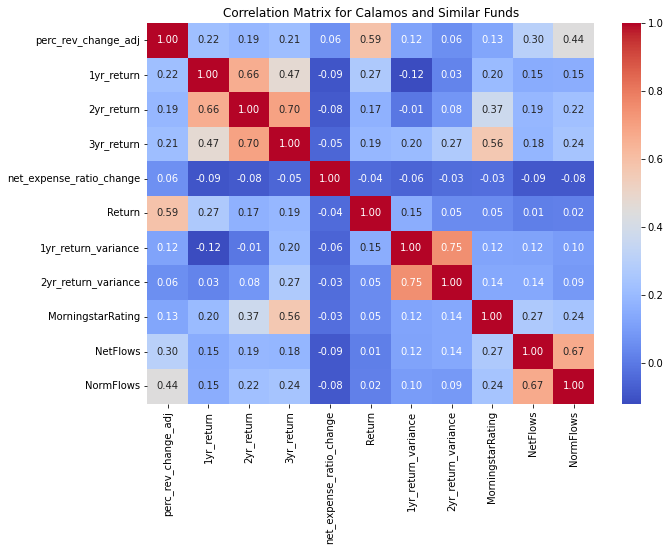

In [0]:
yearly_avg_aum = final_df_for_year.groupby(['Fund', 'Year'])['AUM'].sum().reset_index()

yearly_avg_aum = calculate_weighted_size(yearly_avg_aum)

# Analysis for Calamos and similar funds
calamos_funds = filter_funds_by_name(yearly_avg_aum, 'Calamos')
if not calamos_funds.empty:
    calamos_weighted_size_last = calamos_funds['Weighted_size'].iloc[-1]
    calamos_last_year = calamos_funds['Year'].iloc[-1]
    similar_funds = filter_funds_by_size(yearly_avg_aum, calamos_weighted_size_last, calamos_last_year)
    cleaned_df = merge_and_clean_data(final_df_for_year, similar_funds)
    cleaned_df = calculate_financial_metrics(cleaned_df)
    correlation_analysis(cleaned_df, "Correlation Matrix for Calamos and Similar Funds")
else:
    print("No funds match the criteria specified for Calamos-like analysis.")


<command-1080563877373030>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['AUM'] * df['NetExpenseRatio']
<command-1080563877373030>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perc_rev_change'] = df.groupby('Fund')['revenue'].pct_change() * 100
<command-1080563877373030>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

DataFrame shape: (1194, 19)
Selected columns: ['perc_rev_change_adj', '1yr_return', '2yr_return', '3yr_return', 'net_expense_ratio_change', 'Return', '1yr_return_variance', '2yr_return_variance', 'MorningstarRating', 'NetFlows', 'NormFlows']


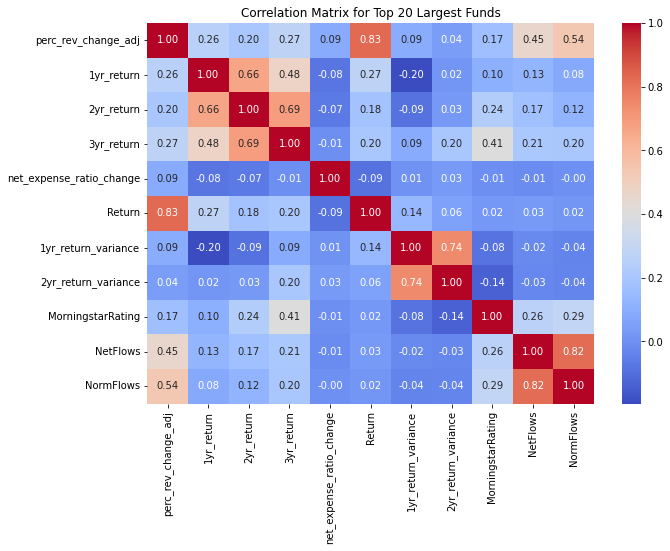

In [0]:
# Analysis for the top 20 largest funds by AUM
top_funds_df = select_top_funds_by_aum(final_df_for_year)
top_funds_df = calculate_financial_metrics(top_funds_df)
correlation_analysis(top_funds_df, "Correlation Matrix for Top 20 Largest Funds")

## Plot Calamos  vs Similar vs Large Funds

<command-1080563877373030>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['AUM'] * df['NetExpenseRatio']
<command-1080563877373030>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perc_rev_change'] = df.groupby('Fund')['revenue'].pct_change() * 100
<command-1080563877373030>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-92876430328751>", line 80, in <module>
    plot_fund_trends(final_df_prepared)
  File "<command-92876430328751>", line 50, in plot_fund_trends
    plot_double_bar_chart(fund_data, label, color, axs[1], ['net_expense_ratio_change'])
  File "<command-92876430328751>", line 34, in plot_double_bar_chart
    ax.bar(x + i*width + offset, year_means[col], width=width, label=f'{label} - {col}' if label not in ax.get_legend_handles_labels()[1] else "", color=color)
TypeError: unsupported operand type(s) for +: 'range' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1997, in showtraceback
    stb = self.InteractiveTB.st

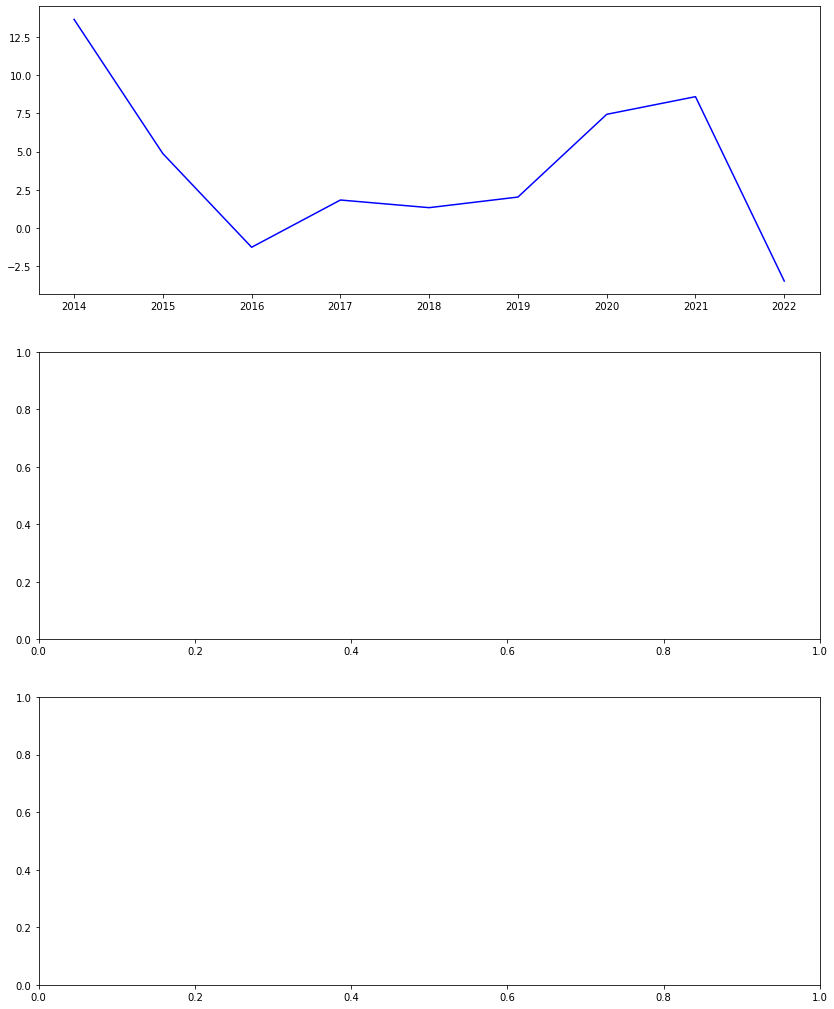

In [0]:
def fetch_calamos_data(df):
    """ Fetch data for Calamos funds. """
    return df[df['Fund'].str.contains('Calamos')]

def fetch_similar_funds_data(df, calamos_funds):
    """ Fetch data for funds similar to Calamos funds based on weighted size criteria. """
    if not calamos_funds.empty:
        weighted_size = calamos_funds['Weighted_size'].iloc[-1]  # Assuming Weighted_size is calculated already
        return df[(df['Weighted_size'] >= weighted_size * 0.7) & (df['Weighted_size'] <= weighted_size * 1.5)]
    else:
        return pd.DataFrame()  # Return empty DataFrame if no Calamos data

def fetch_largest_funds_data(df, n=20):
    """ Fetch data for the largest n funds by AUM. """
    top_funds = df.groupby('Fund')['AUM'].mean().nlargest(n).index
    return df[df['Fund'].isin(top_funds)]


def plot_fund_trends(df):
    """ Plot trends for selected fund categories with labels for 3-year returns only. """

    def plot_trend_with_final_label(sub_df, label, color, ax):
        # Sort the DataFrame by 'Year' and then group by 'Year' to calculate mean values
        sub_df = sub_df.sort_values('Year')
        year_means = sub_df.groupby('Year').mean()
        ax.plot(year_means.index, year_means['perc_rev_change_adj'], label=label, color=color)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Fetch the subsets of data for each category
    calamos_funds = fetch_calamos_data(df)
    similar_funds = fetch_similar_funds_data(df, calamos_funds)
    largest_funds = fetch_largest_funds_data(df)

    # Plot trends for each category with final label
    if not calamos_funds.empty:
        plot_trend_with_final_label(calamos_funds, 'Calamos Funds', 'blue', ax)
    if not similar_funds.empty:
        plot_trend_with_final_label(similar_funds, 'Funds Similar to Calamos', 'green', ax)
    if not largest_funds.empty:
        plot_trend_with_final_label(largest_funds, 'Largest Funds', 'red', ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage Revenue Change Adjusted')
    ax.set_title('Trend Comparison: Calamos, Similar Funds, and Largest Funds')
    ax.legend()
    ax.grid(True)
    plt.show()



final_df_prepared = calculate_financial_metrics(final_df_for_year)
# Now, you can use this prepared DataFrame to plot trends:
final_df_prepared = calculate_weighted_size(final_df_prepared)
plot_fund_trends(final_df_prepared)

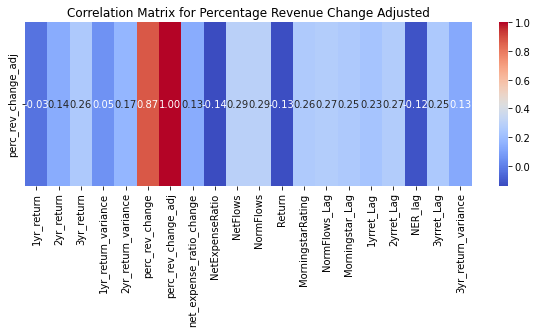

In [0]:
def analyze_fund_performance(df):
    """
    Analyzes fund performance by calculating various metrics, filtering the DataFrame,
    and plotting a correlation matrix for the specified metrics.
    """
    df['MonthEndDate'] = pd.to_datetime(df['MonthEndDate'])
    df_jan = df[df['MonthEndDate'].dt.month == 1].copy()

    df_jan['revenue'] = df_jan['AUM'] * df_jan['NetExpenseRatio']
    df_jan['perc_rev_change'] = df_jan.groupby('Fund')['revenue'].pct_change() * 100
    df_jan['net_expense_ratio_change'] = df_jan.groupby('Fund')['NetExpenseRatio'].diff()
    df_jan['perc_rev_change_adj'] = df_jan['perc_rev_change'] - 100 * df_jan['1yr_return']
    df_jan['NormFlows'] = df_jan['NetFlows'] / df_jan['AUM']
    df_jan['NormFlows_Lag'] = df_jan.groupby('Fund')['NormFlows'].shift(1)
    df_jan['Morningstar_Lag'] = df_jan.groupby('Fund')['MorningstarRating'].shift(1)
    df_jan['1yrret_Lag'] = df_jan.groupby('Fund')['1yr_return'].shift(1)
    df_jan['2yrret_Lag'] = df_jan.groupby('Fund')['2yr_return'].shift(1)
    df_jan['3yrret_Lag'] = df_jan.groupby('Fund')['3yr_return'].shift(1)
    df_jan['NER_lag'] = df_jan.groupby('Fund')['net_expense_ratio_change'].shift(1)

   
    # Filter out non-finite values
    df_jan = df_jan[np.isfinite(df_jan['perc_rev_change_adj'])]

    return df_jan
# Specify the columns for which histograms are to be plotted
columns_to_plot = ['1yr_return', '2yr_return', '3yr_return', '1yr_return_variance', 
                       '2yr_return_variance', 'perc_rev_change', 'perc_rev_change_adj', 
                       'net_expense_ratio_change', 'NetExpenseRatio', 'NetFlows', 'NormFlows', 
                       'Return', 'MorningstarRating', 'NormFlows_Lag', 'Morningstar_Lag', '1yrret_Lag', '2yrret_Lag', 'NER_lag',
                       '3yrret_Lag', '3yr_return_variance']

df_jan = analyze_fund_performance(cleaned_df)
correlation_data = df_jan[columns_to_plot]
correlation_matrix = correlation_data.corr()

 # Plotting correlation matrix for the 'perc_rev_change_adj' row
plt.figure(figsize=(10, 3))
sns.heatmap(correlation_matrix.iloc[6:7, :], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Percentage Revenue Change Adjusted')
plt.show()


## Time Series Model

In [0]:

def fit_var_model(data, lag_order):
    model = VAR(data)
    results = model.fit(lag_order)
    return results


def prepare_data(df):
    """
    Prepare the data by cleaning, standardizing and dropping NaNs.
    """
    # Drop rows with NaN values in specified columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    columns_to_check = ['perc_rev_change_adj', '1yr_return', '2yr_return', 'net_expense_ratio_change', 'NetExpenseRatio', 'NetFlows', 'MorningstarRating']
    df.dropna(subset=columns_to_check + numeric_cols.tolist(), inplace=True)

    # Standardize variables
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

def fit_auto_regression(df, target_col, feature_cols, lag_order=1):
    """
    Fit an AutoReg model to the data with specified features and target.
    """
    X = df[feature_cols]
    y = df[target_col]
    X = add_constant(X)

    model = AutoReg(y, lags=lag_order, exog=X, old_names=False)
    results = model.fit()

    # Create a DataFrame with features, coef, z, and P>z
    summary_df = pd.DataFrame({
        'Features': results.params.index,
        'Coef': results.params.values,
        'z': results.tvalues.values,
        'P>z': results.pvalues.values
    })
    
    # Remove duplicate rows for the constant term
    summary_df = summary_df.drop_duplicates(subset=['Features'])
    
    return summary_df

In [0]:
df_jan = prepare_data(df_jan)  # Assuming df_jan is already loaded
feature_columns = ['1yr_return', '2yr_return', '3yr_return', '2yr_return_variance', '3yr_return_variance', 'net_expense_ratio_change', 'NormFlows_Lag', 'MorningstarRating', '1yrret_Lag', '2yrret_Lag', '3yrret_Lag', 'NER_lag']
auto_reg_summary = fit_auto_regression(df_jan, 'perc_rev_change_adj', feature_columns)
auto_reg_summary

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,Features,Coef,z,P>z
0,const,0.001714,0.042539,0.966069
1,perc_rev_change_adj.L1,0.066535,0.731502,0.464473
3,1yr_return,-1.021514,-1.350170,0.176961
4,2yr_return,2.483469,1.664280,0.096057
5,3yr_return,-0.898768,-0.859664,0.389974
6,2yr_return_variance,0.938233,2.199323,0.027855
7,3yr_return_variance,-0.950333,-2.064495,0.038971
8,net_expense_ratio_change,0.260951,2.735581,0.006227
9,NormFlows_Lag,0.188400,1.782801,0.074619
10,MorningstarRating,0.085647,0.706255,0.480030


## Potential Classification (Ignore)

In [0]:
# Filter data based on year
X_train = X[final_df_jan['Year'] < 2020]
y_train = y[final_df_jan['Year'] < 2020]
X_test = X[final_df_jan['Year'] >= 2020]
y_test = y[final_df_jan['Year'] >= 2020]

# Convert perc_rev_change_adj to binary (positive or negative)
y_binary_train = (y_train > 0).astype(int)
y_binary_test = (y_test > 0).astype(int)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Perform data oversampling to increase the amount of positive class instances
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_binary_train)

# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the Gradient Boosting classifier
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the Gradient Boosting classifier
accuracy = accuracy_score(y_binary_test, y_pred)
print(f'Test Accuracy: {accuracy}')


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3248546186141003>:2
      1 # Filter data based on year
----> 2 X_train = X[final_df_jan['Year'] < 2020]
      3 y_train = y[final_df_jan['Year'] < 2020]
      4 X_test = X[final_df_jan['Year'] >= 2020]

NameError: name 'X' is not defined

In the context of a VAR model, these correlations between residuals indicate whether there might be additional information or relationships between the variables that are not captured by the model.

## Sanity Check: If each month is same

In [0]:
# Filter the filtered_df DataFrame for these fund names
#similar_funds_filtered_df = filtered_df[filtered_df['Fund'].isin(unique_funds)]
similar_funds_filtered_df = filtered_df
# Convert 'MonthEndDate' to datetime if it's not already in datetime format
similar_funds_filtered_df['MonthEndDate'] = pd.to_datetime(similar_funds_filtered_df['MonthEndDate'])

# Define the list of months
months = [1, 6, 10]
for month in months:
    # Filter for rows where MonthEndDate corresponds to the specified month
    final_df_filtered = similar_funds_filtered_df[similar_funds_filtered_df['MonthEndDate'].dt.month == month].copy()  

    final_df_filtered['revenue'] = final_df_filtered['AUM'] * final_df_filtered['NetExpenseRatio']
    # Calculate percentage revenue change from the previous month
    final_df_filtered['perc_rev_change'] = final_df_filtered.groupby('Fund')['revenue'].pct_change() * 100
    final_df_filtered['net_expense_ratio_change'] = final_df_filtered.groupby('Fund')['NetExpenseRatio'].diff()
    final_df_filtered['perc_rev_change_adj'] = final_df_filtered['perc_rev_change'] - 100 * final_df_filtered['1yr_return']
    final_df_filtered['NormFlows'] = final_df_filtered['NetFlows'] / final_df_filtered['AUM']

    # Apply log transformation to '1yr_return_variance' and '2yr_return_variance'
    final_df_filtered['1yr_return_variance_log'] = np.log(final_df_filtered['1yr_return_variance'])
    final_df_filtered['2yr_return_variance_log'] = np.log(final_df_filtered['2yr_return_variance'])

    # Create binary columns for positive/negative values of 'perc_rev_change_adj', 'net_expense_ratio_change', and '1yr_return'
    final_df_filtered['perc_rev_change_adj_sign'] = np.where(final_df_filtered['perc_rev_change_adj'] > 0, 1, 0)
    final_df_filtered['net_expense_ratio_change_sign'] = np.where(final_df_filtered['net_expense_ratio_change'] > 0, 1, 0)
    final_df_filtered['1yr_return_sign'] = np.where(final_df_filtered['1yr_return'] > 0, 1, 0)

    
    # Selecting relevant columns for correlation calculation
    selected_columns = ['perc_rev_change_adj', '1yr_return', '2yr_return', 'net_expense_ratio_change', 'NetExpenseRatio', '2yr_return_variance_log', '1yr_return_variance_log', 'MorningstarRating', 'perc_rev_change', 'NetFlows', 'NormFlows',
                        'perc_rev_change_adj_sign', 'net_expense_ratio_change_sign', '1yr_return_sign']
    correlation_data = final_df_filtered[selected_columns]
    
    # Calculating correlation matrix
    correlation_matrix = correlation_data.corr()
    
    # Plotting correlation matrix
    plt.figure(figsize=(10, 3))
    sns.heatmap(correlation_matrix.iloc[:, :], annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for Month {month}')
    plt.show()
